# Example MNIST DCGAN

This notebook shows how to create, train and perform prediction with a `conditionned MNIST DCGAN`.

If you want to not condition the model, you can simply put `labels = None` in the `config` variables ! The `conditionned` version takes an additional input which is a `one-hot encoding` of the expected label

## Imports + model initialization

In [1]:
import pandas as pd
import tensorflow as tf

from utils.image import display_image
from utils import plot, plot_multiple, set_display_options
from datasets import get_dataset, prepare_dataset, test_dataset_time
from models.generation import DCGAN
from custom_train_objects.optimizers import SinScheduler

set_display_options()

model_name = 'mnist_dcgan_cond'
print("Tensorflow version : {}".format(tf.__version__))

Tensorflow version : 2.10.0


In [2]:
config = {
    'image_shape' : (28, 28, 1),
    'labels'      : list(range(10)),
    'gen_kwargs'  : {
        'conv_input_channels' : 256,
        'n_blocks' : 2,
        'filters' : [128, 64],
        'kernel_size' : 5,
        'final_kernel_size' : 5,
        'strides' : [1, 2],
        'final_strides' : 2,
        'activation'    : 'leaky',
        'drop_rate'     : 0.
    },
    'dis_kwargs'  : {
        'n_conv' : 2,
        'filters'     : [64, 128],
        'kernel_size' : 5,
        'strides'     : 2,
        'activation'  : 'leaky',
        'drop_rate'   : 0.2
    }
}
model = DCGAN(noise_size = 100, nom = model_name, ** config)

print(model)
model.summary()

Model restoration...
Initializing submodel : `generator` !
Successfully restored generator from pretrained_models/mnist_dcgan_cond/saving/generator.json !
Initializing submodel : `discriminator` !
Successfully restored discriminator from pretrained_models/mnist_dcgan_cond/saving/discriminator.json !
Optimizer 'generator_optimizer' initilized successfully !
Optimizer 'discriminator_optimizer' initilized successfully !
[WARNING] Some layers have not bene restored from the checkpoint ! Run `model.load_checkpoint().assert_consumed()` to check if it is a critical error or not
Model mnist_dcgan_cond initialized successfully !

========== mnist_dcgan_cond ==========
Sub model generator
- Inputs 	: [(None, 100), (None, 10)]
- Outputs 	: (None, 28, 28, 1)
- Number of layers 	: 15
- Number of parameters 	: 2.456 Millions
- Model not compiled

Sub model discriminator
- Inputs 	: (None, 28, 28, 1)
- Outputs 	: [(None, 1), (None, 10)]
- Number of layers 	: 14
- Number of parameters 	: 0.276 Million

## Model instanciation + dataset loading

In [3]:
model = DCGAN(nom = model_name)

gen_lr = 1e-4 #SinScheduler(period = 1024, minval = 1e-4, maxval = 5e-4)
dis_lr = 1e-4 #SinScheduler(period = 512, minval = 1e-4, maxval = 5e-4)

model.compile(
    loss_kwargs          = {
        'scale_gen_loss' : False, 'one_sided_smoothing' : True, 'dis_smoothed_value' : 1e-3
    },
    gen_optimizer_kwargs = {'lr' : gen_lr},
    dis_optimizer_kwargs = {'lr' : dis_lr}
)

print(model)

Models already compiled !

========== mnist_dcgan_cond ==========
Sub model generator
- Inputs 	: [(None, 100), (None, 10)]
- Outputs 	: (None, 28, 28, 1)
- Number of layers 	: 15
- Number of parameters 	: 2.456 Millions
- Model not compiled

Sub model discriminator
- Inputs 	: (None, 28, 28, 1)
- Outputs 	: [(None, 1), (None, 10)]
- Number of layers 	: 14
- Number of parameters 	: 0.276 Millions
- Model not compiled

Total number of layers : 29
Total number of parameters : 2.733 Millions
Already trained on 10 epochs (2350 steps)

Optimizers :
- generator_optimizer :	{'name': 'Adam', 'learning_rate': 9.999999747378752e-05, 'decay': 0.0, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'epsilon': 1e-07, 'amsgrad': False}
- discriminator_optimizer :	{'name': 'Adam', 'learning_rate': 9.999999747378752e-05, 'decay': 0.0, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'epsilon': 1e-07, 'amsgrad': False}

Losses :
- gan_loss :	{'reduction': 'none', 'name': None, 'labe

In [4]:
ds = get_dataset('mnist')

train, valid = ds['train'], ds['test']
print(train)
print(valid)

<PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
<PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


## Training + history analysis

In [5]:
epochs = 10
batch_size = 256

model.train(
    train, validation_data = valid,
    epochs = epochs, batch_size = batch_size,
    augment_prct = 0., min_update_accuracy = 0.
)

Training config :
HParams :
- augment_prct	: 0.0
- min_update_accuracy	: 0.0
- batch_size	: 256
- train_batch_size	: None
- valid_batch_size	: None
- test_batch_size	: 1
- shuffle_size	: 1024
- epochs	: 10
- verbose	: 1
- train_times	: 1
- valid_times	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: -1

Running on 1 GPU

Epoch 11 / 20
Epoch 11/10
235/235 [==============================] - 23s 64ms/step - loss: 5.0145 - gen_loss: 2.1410 - dis_loss: 2.8735 - dis_true_loss: 2.1575 - dis_fake_loss: 0.7160 - gen_reality_loss: 0.6750 - gen_label_loss: 1.4661 - dis_reality_loss: 0.6530 - dis_label_loss: 1.5045 - gen_realism: 0.9835 - dis_true_accuracy: 0.9478 - gen_label: 0.9980 - dis_label: 0.9659 - val_loss: 5.0341 - val_gen_loss: 2.1542 - val_dis_loss: 2.8799 - val_dis_true_loss: 2.1865 - val_dis_fake_loss: 0.6933 - val_gen_reality_loss: 0.6930 - val_gen_label_loss: 1.4612 - val_dis_reality_loss: 0.6929 - val_dis_label_loss: 1.4936 - val_gen_realism: 0.9870 - val_d

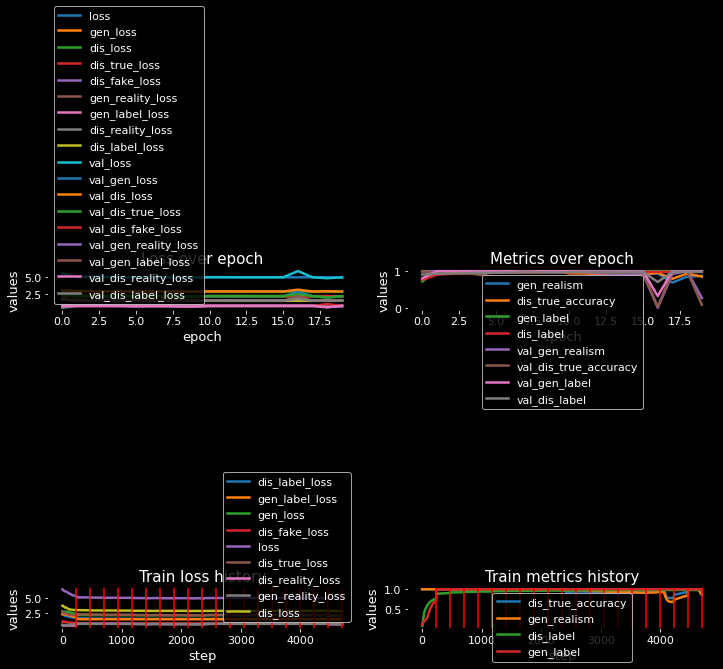

In [6]:
model.plot_history()

## Prediction

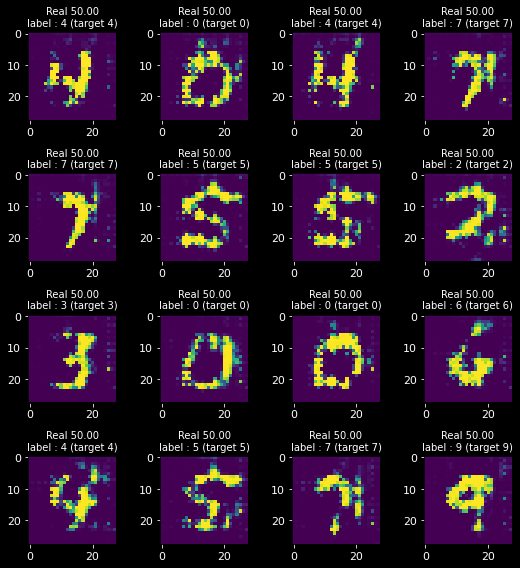

In [7]:
_ = model.predict(n = 16, size = 2, titlesize = 10, filename = 'test.png', show = True)

In [ ]:
from utils.image import display_image

display_image(model.build_gif(n_repeat = 2, keep_frames = 5))

## Configure `learning rate schedulers`

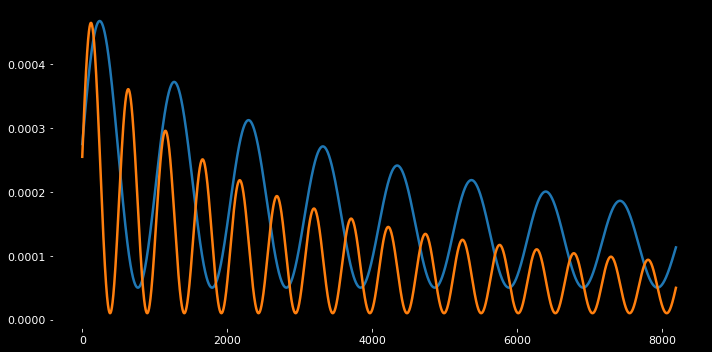

In [9]:
gen_lr = SinScheduler(period = 1024, minval = 5e-5, maxval = 5e-4)
dis_lr = SinScheduler(period = 512, minval = 1e-5, maxval = 5e-4)

_ = plot_multiple(gen_lr = gen_lr, dis_lr = dis_lr, x = range(1024 * 8), x_size = 10)

## Test dataset performance

In [10]:
config = model.get_dataset_config(is_validation = False, batch_size = 128, shuffle_size = 0)

ds_train = prepare_dataset(train, ** config, debug = True)
test_dataset_time(ds_train, steps = 100)

 99%|███████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:00<00:00, 116.40it/s]


100 batchs in 857 ms sec (116.680 batch / sec)

Time estimated for all dataset (469 batch) : 15h 12min 3sec
Batch infos : 
Item 0 : 
 Item 0 : 
  Item 0 : shape : (128, 100) - type : float32- min : -4.092 - max : 3.783
  Item 1 : shape : (128, 10) - type : float32- min : 0.000 - max : 1.000
 Item 1 : shape : (128, 28, 28, 1) - type : float32- min : -1.000 - max : 1.000
Item 1 : 
 Item 0 : 
  Item 0 : shape : (128, 10) - type : float32- min : 0.000 - max : 1.000
 Item 1 : 
  Item 0 : shape : (128, 10) - type : float32- min : 0.000 - max : 1.000


0.8570413589477539